In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from IPython.display import display, HTML
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
def graphRes(act, pred):
    ax = plt.gca()
    for pos in positions:
        ax.scatter(act[pos],pred[pos], label=f'{pos} ({r2_score(act[pos], pred[pos]).round(2)})')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels)
    ax.plot(act['QB'],act['QB'],color='black') # y==x reference line
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

def printStats(y_dev, y_pred):
    graphRes(y_dev, y_pred)

    stats = pd.DataFrame(index = ['MAE','RMSE','R^2'], columns = [positions])
    for pos in positions:
        stats.loc['MAE',pos] = mean_absolute_error(y_dev[pos], y_pred[pos]).round(1)
        stats.loc['RMSE',pos] = round(math.sqrt(mean_squared_error(y_dev[pos], y_pred[pos])),1)
        stats.loc['R^2',pos] = r2_score(y_dev[pos], y_pred[pos]).round(2)
    
    display(stats)
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


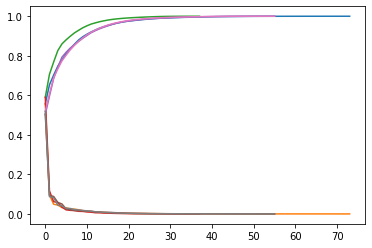

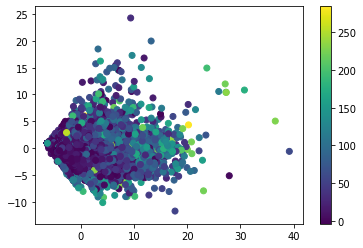

In [3]:
# Partition training, dev, and test data
positions = ['QB','RB','WR','TE']
X_train, X_dev, X_test = {}, {}, {}
y_train, y_dev, y_test = {}, {}, {}
data = {}
for pos in positions:
    Xy = pd.read_csv(f'../{pos}.csv').dropna(subset=['fanPts'])
    data[pos] = Xy
    X = Xy.loc[:,Xy.columns.str.contains('-\d+') | Xy.columns.str.match('fanPts')] \
        .drop('fanPts',axis=1) \
        .fillna(0)
    y = Xy.fanPts
    
    # Split
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.3, random_state=0)
    X_dev_raw, X_test_raw, y_dev_raw, y_test_raw = train_test_split(X_test_raw, y_test_raw, test_size=0.5, random_state=0)
    
    # Scale X data
    ss = preprocessing.StandardScaler()
    X_train[pos] = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
    X_dev[pos] = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
    X_test[pos] = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)
    
    # Leave y data in original units
    y_train[pos] = y_train_raw
    y_dev[pos] = y_dev_raw
    y_test[pos] = y_test_raw

# PCA
pca = {}
pc = {}
X_train_pc = {}
X_dev_pc = {}
X_test_pc = {}
for pos in positions:
    pca[pos] = PCA(n_components='mle')
    pc[pos] = pca[pos].fit(X_train[pos])
    plt.plot(np.cumsum(pca[pos].explained_variance_ratio_))
    plt.plot(pca[pos].explained_variance_ratio_)
plt.show()

for pos in positions:
    X_train[pos] = pd.DataFrame(pca[pos].transform(X_train[pos]))
    X_dev[pos] = pd.DataFrame(pca[pos].transform(X_dev[pos]))
    X_test[pos] = pd.DataFrame(pca[pos].transform(X_test[pos]))
    plt.scatter(X_train[pos][0],X_train[pos][1],c=y_train[pos])
plt.colorbar()
plt.show()

### LASSO Regression

#### Base model

,6.000,0.000,1.000,16.000,28.000,7.000,21.000,14.000,12.000,25.000,2.000,18.000,10.000,9.000,3.000,20.000,11.000,5.000,13.000,4.000,17.000,27.000,24.000,22.000,19.000,72.000,23.000,15.000,26.000,8.000,29.000,30.000,31.000,32.000,33.000,34.000,35.000,73.000,37.000,38.000,57.000,58.000,59.000,60.000,61.000,62.000,63.000,64.000,65.000,66.000,67.000,68.000,69.000,70.000,71.000,56.000,55.000,54.000,45.000,39.000,40.000,41.000,42.000,43.000,44.000,46.000,53.000,47.000,48.000,49.000,50.000,51.000,52.000,36.000
1,18.871,10.047,-9.181,-8.395,8.151,-5.413,5.265,-4.221,-3.700,3.646,2.230,-2.099,-1.916,1.895,-1.887,-1.511,-1.494,-1.252,-1.086,-0.597,0.559,0.529,-0.493,-0.340,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000


,6.000,1.000,0.000,2.000,7.000,11.000,4.000,13.000,19.000,3.000,23.000,9.000,10.000,12.000,17.000,8.000,14.000,15.000,5.000,16.000,37.000,36.000,29.000,35.000,34.000,33.000,32.000,31.000,30.000,28.000,20.000,27.000,26.000,25.000,24.000,22.000,21.000,18.000
1,-13.006,-8.966,8.442,8.281,-5.404,5.219,4.449,3.418,2.154,-2.004,0.674,0.222,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000


,0.000,1.000,5.000,2.000,8.000,19.000,9.000,11.000,7.000,17.000,15.000,13.000,12.000,4.000,3.000,10.000,54.000,14.000,6.000,16.000,18.000,20.000,21.000,22.000,23.000,24.000,25.000,26.000,55.000,28.000,42.000,53.000,52.000,51.000,50.000,49.000,48.000,47.000,46.000,45.000,44.000,43.000,41.000,29.000,40.000,39.000,38.000,37.000,36.000,35.000,34.000,33.000,32.000,31.000,30.000,27.000
1,7.184,7.051,-5.840,5.248,4.316,-4.288,3.037,3.020,2.525,-2.339,-1.929,-1.774,1.684,-1.440,-0.241,0.217,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000


,1.000,9.000,0.000,14.000,13.000,3.000,2.000,4.000,17.000,6.000,26.000,19.000,18.000,25.000,24.000,23.000,22.000,21.000,20.000,10.000,11.000,7.000,16.000,5.000,8.000,54.000,12.000,15.000,55.000,28.000,42.000,53.000,52.000,51.000,50.000,49.000,48.000,47.000,46.000,45.000,44.000,43.000,41.000,29.000,40.000,39.000,38.000,37.000,36.000,35.000,34.000,33.000,32.000,31.000,30.000,27.000
1,5.478,-4.979,4.358,3.374,-3.095,1.895,-1.275,1.104,1.098,-0.842,0.755,0.585,0.045,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000


,QB,RB,WR,TE
MAE,61.300,44.500,38.100,21.400
RMSE,81.000,61.800,55.400,30.100
R^2,0.440,0.430,0.420,0.480


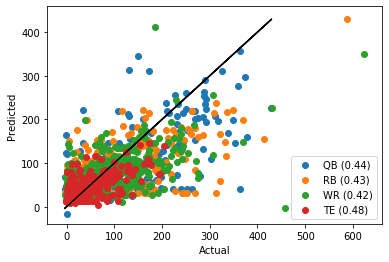

In [4]:
y_pred = {}
for pos in positions:
    m = linear_model.Lasso()
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    coefs = pd.DataFrame([X_train[pos].columns,m.coef_]).transpose()
    display(coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose())
    
printStats(y_dev, y_pred)

#### GridSearchCV

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    4.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


,6.000,0.000,1.000,16.000,28.000,7.000,21.000,14.000,12.000,25.000,2.000,18.000,10.000,9.000,3.000,20.000,11.000,5.000,13.000,4.000,17.000,27.000,24.000,22.000,19.000,72.000,23.000,15.000,26.000,8.000,29.000,30.000,31.000,32.000,33.000,34.000,35.000,73.000,37.000,38.000,57.000,58.000,59.000,60.000,61.000,62.000,63.000,64.000,65.000,66.000,67.000,68.000,69.000,70.000,71.000,56.000,55.000,54.000,45.000,39.000,40.000,41.000,42.000,43.000,44.000,46.000,53.000,47.000,48.000,49.000,50.000,51.000,52.000,36.000
1,18.871,10.047,-9.181,-8.395,8.151,-5.413,5.265,-4.221,-3.700,3.646,2.230,-2.099,-1.916,1.895,-1.887,-1.511,-1.494,-1.252,-1.086,-0.597,0.559,0.529,-0.493,-0.340,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000


,33.000,23.000,19.000,24.000,6.000,28.000,29.000,26.000,21.000,1.000,20.000,2.000,0.000,11.000,13.000,7.000,25.000,31.000,4.000,18.000,3.000,16.000,22.000,9.000,12.000,10.000,8.000,27.000,5.000,17.000,36.000,30.000,14.000,32.000,15.000,34.000,35.000,37.000
1,29.986,21.809,15.851,14.806,-14.273,-13.572,11.082,-9.773,-9.663,-9.165,9.106,8.654,8.481,7.878,7.505,-6.773,-5.872,-5.266,5.126,3.157,-2.401,-2.259,-2.126,2.048,1.998,-1.100,0.534,-0.187,0.151,0.064,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000


,0.000,1.000,5.000,2.000,8.000,19.000,9.000,11.000,7.000,17.000,15.000,13.000,12.000,4.000,3.000,10.000,54.000,14.000,6.000,16.000,18.000,20.000,21.000,22.000,23.000,24.000,25.000,26.000,55.000,28.000,42.000,53.000,52.000,51.000,50.000,49.000,48.000,47.000,46.000,45.000,44.000,43.000,41.000,29.000,40.000,39.000,38.000,37.000,36.000,35.000,34.000,33.000,32.000,31.000,30.000,27.000
1,7.184,7.051,-5.840,5.248,4.316,-4.288,3.037,3.020,2.525,-2.339,-1.929,-1.774,1.684,-1.440,-0.241,0.217,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000


,35.000,26.000,41.000,32.000,9.000,1.000,30.000,14.000,29.000,19.000,13.000,25.000,0.000,23.000,17.000,28.000,18.000,24.000,31.000,44.000,38.000,22.000,34.000,3.000,16.000,37.000,4.000,2.000,6.000,12.000,11.000,7.000,5.000,8.000,15.000,10.000,55.000,20.000,46.000,53.000,52.000,51.000,50.000,49.000,48.000,47.000,45.000,21.000,43.000,42.000,40.000,39.000,36.000,33.000,54.000,27.000
1,13.025,11.739,-10.915,-10.271,-5.870,5.658,-5.441,5.291,-5.038,4.852,-4.749,4.512,4.388,-4.247,4.236,-4.003,3.564,3.533,3.303,-3.253,3.182,2.533,-2.361,2.250,-1.619,-1.586,1.486,-1.467,-1.417,1.100,-0.818,-0.520,0.496,-0.313,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000


QB: {'alpha': 1}
RB: {'alpha': 0.1}
WR: {'alpha': 1}
TE: {'alpha': 0.1}


,QB,RB,WR,TE
MAE,61.300,44.400,38.100,20.900
RMSE,81.000,61.900,55.400,30.600
R^2,0.440,0.430,0.420,0.460


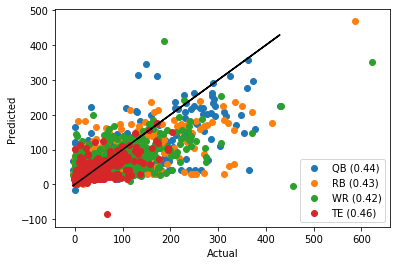

In [5]:
y_pred = {}
bestParams = {}
coefs = {}
for pos in positions:
    params = {
    'alpha':[10**x for x in range(-4,6)],
}

    grid = GridSearchCV(
        linear_model.Lasso(),
        params,
        n_jobs = -1,
        verbose = 7,
        cv = 5
    ).fit(X_train[pos],y_train[pos])

    bestParams[pos] = grid.best_params_

    m = linear_model.Lasso(**grid.best_params_)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    coefs[pos] = pd.DataFrame([X_train[pos].columns,m.coef_]).transpose()

    
for pos in positions:
    display(coefs[pos].reindex(coefs[pos][1].abs().sort_values(ascending=False).index).set_index(0).transpose())
    
for pos in positions:
    print(f'{pos}: {bestParams[pos]}')
printStats(y_dev,y_pred)

#### Automatic CV

,6.000,0.000,1.000,16.000,7.000,14.000,12.000,2.000,3.000,9.000,10.000,5.000,11.000,4.000,24.000,33.000,34.000,32.000,31.000,30.000,29.000,28.000,27.000,26.000,25.000,17.000,23.000,22.000,21.000,20.000,19.000,18.000,72.000,15.000,13.000,8.000,35.000,73.000,37.000,38.000,57.000,58.000,59.000,60.000,61.000,62.000,63.000,64.000,65.000,66.000,67.000,68.000,69.000,70.000,71.000,56.000,55.000,54.000,45.000,39.000,40.000,41.000,42.000,43.000,44.000,46.000,53.000,47.000,48.000,49.000,50.000,51.000,52.000,36.000
1,18.357,10.024,-9.049,-6.125,-4.884,-2.507,-2.398,1.971,-1.604,1.117,-0.923,-0.839,-0.386,-0.203,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000


,6.000,23.000,1.000,0.000,2.000,19.000,11.000,7.000,13.000,4.000,3.000,9.000,24.000,20.000,21.000,10.000,15.000,12.000,8.000,5.000,14.000,37.000,16.000,17.000,36.000,22.000,25.000,26.000,27.000,28.000,29.000,30.000,31.000,32.000,33.000,34.000,35.000,18.000
1,-13.574,10.155,-9.055,8.459,8.448,8.298,6.412,-6.018,5.251,4.753,-2.182,1.041,0.640,0.334,-0.044,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000


,36.000,30.000,26.000,31.000,19.000,0.000,1.000,25.000,5.000,2.000,8.000,22.000,17.000,21.000,28.000,11.000,9.000,15.000,7.000,13.000,12.000,20.000,27.000,23.000,4.000,10.000,3.000,6.000,14.000,48.000,45.000,46.000,47.000,32.000,49.000,44.000,51.000,52.000,53.000,50.000,16.000,33.000,43.000,18.000,42.000,41.000,40.000,39.000,24.000,38.000,37.000,54.000,35.000,29.000,34.000,55.000
1,-10.962,-9.742,7.945,-7.745,-7.419,7.209,7.188,7.125,-6.355,5.392,5.092,4.770,-4.396,-4.360,-4.000,3.938,3.851,-3.678,3.260,-3.134,2.914,-2.326,-2.138,-1.763,-1.694,1.113,-0.460,0.391,0.106,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000


,26.000,1.000,9.000,0.000,14.000,13.000,19.000,17.000,3.000,18.000,2.000,4.000,6.000,16.000,12.000,5.000,11.000,7.000,23.000,22.000,25.000,24.000,8.000,21.000,20.000,54.000,10.000,15.000,55.000,28.000,42.000,53.000,52.000,51.000,50.000,49.000,48.000,47.000,46.000,45.000,44.000,43.000,41.000,29.000,40.000,39.000,38.000,37.000,36.000,35.000,34.000,33.000,32.000,31.000,30.000,27.000
1,6.091,5.565,-5.412,4.372,4.305,-3.899,2.658,2.623,2.068,1.754,-1.368,1.290,-1.121,-0.363,0.357,0.211,-0.196,-0.154,-0.114,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000


,QB,RB,WR,TE
MAE,60.900,44.500,37.800,21.100
RMSE,80.400,61.900,55.500,30.100
R^2,0.450,0.430,0.420,0.480


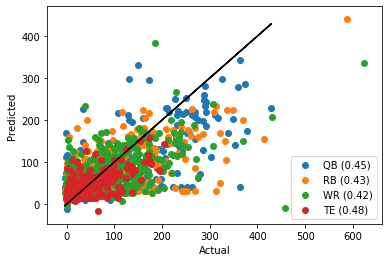

In [6]:
y_pred = {}
for pos in positions:
    m = linear_model.LassoCV(max_iter=5000)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    coefs = pd.DataFrame([X_train[pos].columns,m.coef_]).transpose()
    display(coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose())
    
printStats(y_dev, y_pred)

### Elastic Net Regression

#### Base model

,6.000,0.000,1.000,7.000,16.000,14.000,12.000,21.000,2.000,28.000,3.000,9.000,10.000,25.000,18.000,11.000,5.000,20.000,13.000,27.000,38.000,24.000,22.000,17.000,31.000,4.000,15.000,47.000,8.000,26.000,23.000,29.000,30.000,19.000,32.000,35.000,33.000,34.000,73.000,72.000,64.000,58.000,59.000,60.000,61.000,62.000,63.000,65.000,56.000,66.000,67.000,68.000,69.000,70.000,71.000,57.000,55.000,37.000,45.000,39.000,40.000,41.000,42.000,43.000,44.000,46.000,54.000,48.000,49.000,50.000,51.000,52.000,53.000,36.000
1,15.076,9.940,-8.650,-4.454,-4.375,-2.696,-2.604,2.101,2.083,2.006,-1.772,1.635,-1.602,1.575,-1.445,-1.312,-1.207,-1.164,-1.050,0.915,-0.885,-0.883,-0.832,0.805,0.756,-0.666,0.489,-0.115,-0.015,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000


,0.000,1.000,6.000,2.000,4.000,7.000,11.000,3.000,13.000,19.000,23.000,9.000,24.000,20.000,21.000,12.000,10.000,15.000,8.000,5.000,14.000,37.000,16.000,17.000,36.000,22.000,25.000,26.000,27.000,28.000,29.000,30.000,31.000,32.000,33.000,34.000,35.000,18.000
1,8.284,-8.175,-8.045,7.032,3.507,-3.501,2.704,-1.822,1.739,1.134,0.974,0.614,0.222,0.207,-0.179,0.096,-0.034,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000


,0.000,1.000,2.000,5.000,8.000,9.000,11.000,19.000,7.000,17.000,15.000,13.000,4.000,12.000,22.000,26.000,25.000,21.000,10.000,30.000,3.000,31.000,20.000,36.000,6.000,28.000,23.000,16.000,24.000,18.000,14.000,55.000,54.000,29.000,53.000,52.000,51.000,50.000,49.000,48.000,47.000,46.000,45.000,44.000,43.000,42.000,41.000,40.000,39.000,38.000,37.000,35.000,34.000,33.000,32.000,27.000
1,7.078,6.530,4.865,-4.574,3.161,2.305,2.237,-2.042,2.013,-1.554,-1.422,-1.400,-1.375,1.370,0.741,0.717,0.684,-0.662,0.515,-0.475,-0.340,-0.284,-0.232,-0.224,0.145,-0.025,-0.001,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000


,1.000,0.000,9.000,14.000,13.000,3.000,2.000,4.000,17.000,26.000,6.000,19.000,18.000,12.000,16.000,5.000,11.000,7.000,23.000,22.000,25.000,24.000,8.000,21.000,20.000,10.000,54.000,15.000,55.000,28.000,42.000,53.000,52.000,51.000,50.000,49.000,48.000,47.000,46.000,45.000,44.000,43.000,41.000,29.000,40.000,39.000,38.000,37.000,36.000,35.000,34.000,33.000,32.000,31.000,30.000,27.000
1,5.069,4.302,-3.662,2.150,-2.092,1.747,-1.248,1.086,1.036,0.965,-0.880,0.877,0.677,0.254,-0.226,0.191,-0.168,-0.146,-0.123,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000


,QB,RB,WR,TE
MAE,61.200,44.900,38.200,21.600
RMSE,80.800,62.100,55.300,30.100
R^2,0.450,0.420,0.420,0.480


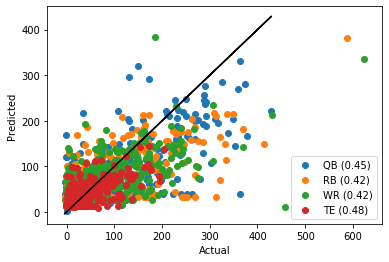

In [7]:
y_pred = {}
for pos in positions:
    m = linear_model.ElasticNet()
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    coefs = pd.DataFrame([X_train[pos].columns,m.coef_]).transpose()
    display(coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose())
    
printStats(y_dev, y_pred)

#### GridSearchCV

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    3.8s finished
C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2968409.987201398, tolerance: 1210.6869544680114
  positive)
C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2968409.987201398, tolerance: 1210.6869544680114
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 491 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 535 out of 550 | elapsed:    7.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    7.7s finished
C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3485179.346596676, tolerance: 1281.321875899531
  positive)
C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3485179.346596676, tolerance: 1281.321875899531
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 535 out of 550 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    3.8s finished
C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 791313.5578970462, tolerance: 287.3882802977049
  positive)
C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 791313.5578970462, tolerance: 287.3882802977049
  positive)


,6.000,0.000,1.000,28.000,16.000,38.000,21.000,25.000,31.000,7.000,14.000,27.000,47.000,12.000,24.000,43.000,20.000,22.000,18.000,39.000,35.000,34.000,58.000,37.000,10.000,48.000,9.000,32.000,17.000,44.000,2.000,11.000,36.000,13.000,30.000,3.000,54.000,49.000,59.000,46.000,51.000,26.000,15.000,5.000,23.000,42.000,41.000,52.000,61.000,63.000,4.000,56.000,62.000,19.000,66.000,50.000,60.000,68.000,33.000,57.000,67.000,65.000,53.000,8.000,55.000,29.000,64.000,69.000,45.000,40.000,70.000,71.000,72.000,73.000
1,18.417,10.047,-9.192,9.167,-8.704,-7.448,6.994,6.307,5.840,-5.655,-5.101,5.047,-4.952,-4.457,-4.293,4.134,-4.042,-3.913,-3.897,-3.622,-3.415,-3.241,-3.118,2.955,-2.679,-2.621,2.507,2.476,2.463,2.453,2.436,-2.380,-2.237,-2.207,2.186,-2.121,1.965,1.938,-1.926,-1.839,1.825,-1.704,1.695,-1.615,-1.385,-1.297,-1.238,-1.160,-1.073,-1.059,-0.971,-0.914,-0.891,0.851,0.812,-0.599,0.557,0.537,-0.499,-0.485,-0.480,-0.443,0.385,-0.313,-0.285,0.282,0.210,0.210,-0.157,0.101,-0.089,0.012,0.000,0.000


,6.000,1.000,23.000,0.000,2.000,19.000,11.000,7.000,13.000,24.000,4.000,21.000,20.000,28.000,26.000,29.000,25.000,33.000,3.000,18.000,9.000,16.000,12.000,22.000,31.000,10.000,27.000,34.000,8.000,30.000,17.000,5.000,32.000,35.000,36.000,14.000,15.000,37.000
1,-13.082,-9.041,8.871,8.458,8.438,8.191,6.699,-6.217,5.936,5.605,4.919,-4.676,4.623,-3.795,-3.657,2.880,-2.555,2.476,-2.359,2.158,1.918,-1.797,1.770,-1.433,-1.432,-1.085,-0.787,-0.664,0.590,-0.535,0.449,0.220,-0.202,0.040,0.000,0.000,0.000,0.000


,0.000,1.000,5.000,19.000,2.000,30.000,26.000,8.000,25.000,36.000,31.000,17.000,22.000,11.000,9.000,21.000,15.000,7.000,28.000,13.000,12.000,27.000,20.000,23.000,33.000,4.000,39.000,38.000,40.000,10.000,34.000,46.000,35.000,24.000,43.000,41.000,42.000,45.000,14.000,6.000,53.000,32.000,3.000,16.000,50.000,37.000,29.000,47.000,48.000,52.000,49.000,44.000,18.000,51.000,55.000,54.000
1,7.194,7.105,-6.115,-6.009,5.341,-5.072,5.066,4.865,4.793,-4.708,-4.391,-4.030,3.951,3.803,3.739,-3.713,-3.496,3.212,-3.211,-3.072,2.889,-2.492,-2.482,-2.189,-1.876,-1.729,-1.683,-1.585,-1.446,1.291,1.266,1.194,-1.180,-1.000,-0.970,-0.931,-0.825,0.781,0.589,0.569,-0.560,-0.542,-0.527,0.512,0.493,-0.385,-0.379,0.341,0.338,-0.225,0.220,-0.205,-0.144,-0.070,0.000,0.000


,26.000,1.000,9.000,14.000,0.000,13.000,19.000,32.000,35.000,17.000,18.000,23.000,25.000,29.000,30.000,41.000,3.000,24.000,28.000,22.000,31.000,16.000,4.000,2.000,6.000,38.000,34.000,44.000,37.000,12.000,11.000,39.000,50.000,43.000,49.000,7.000,36.000,33.000,5.000,51.000,45.000,8.000,52.000,20.000,40.000,15.000,53.000,47.000,48.000,10.000,27.000,42.000,21.000,46.000,54.000,55.000
1,5.836,5.567,-5.431,4.537,4.377,-4.167,3.613,-3.426,3.410,3.399,2.843,-2.715,2.590,-2.415,-2.397,-2.219,2.203,2.202,-2.124,1.850,1.622,-1.487,1.466,-1.458,-1.392,1.389,-1.293,-1.206,-1.108,1.086,-0.840,-0.647,0.620,0.597,-0.559,-0.555,-0.553,0.545,0.525,-0.495,0.488,-0.368,0.194,0.180,0.143,0.103,0.093,0.093,-0.082,0.072,0.065,-0.033,0.031,-0.020,0.000,0.000


QB: {'alpha': 0.1, 'l1_ratio': 0.0}
RB: {'alpha': 0.1, 'l1_ratio': 0.3}
WR: {'alpha': 0.1, 'l1_ratio': 0.0}
TE: {'alpha': 0.1, 'l1_ratio': 0.0}


,QB,RB,WR,TE
MAE,61.600,44.300,37.800,20.900
RMSE,81.500,61.500,55.400,30.100
R^2,0.440,0.430,0.420,0.480


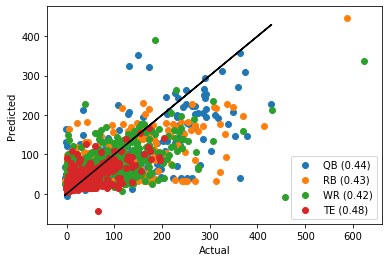

In [8]:
y_pred = {}
bestParams = {}
coefs = {}
for pos in positions:
    params = {
    'alpha':[10**x for x in range(-4,6)],
    'l1_ratio':[x/10 for x in range (0,11)]
}

    grid = GridSearchCV(
        linear_model.ElasticNet(),
        params,
        n_jobs = -1,
        verbose = 7,
        cv = 5
    ).fit(X_train[pos],y_train[pos])

    bestParams[pos] = grid.best_params_

    m = linear_model.ElasticNet(**grid.best_params_)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    coefs[pos] = pd.DataFrame([X_train[pos].columns,m.coef_]).transpose()

    
for pos in positions:
    display(coefs[pos].reindex(coefs[pos][1].abs().sort_values(ascending=False).index).set_index(0).transpose())
    
for pos in positions:
    print(f'{pos}: {bestParams[pos]}')
printStats(y_dev,y_pred)

#### Automatic CV

,6.000,0.000,1.000,16.000,7.000,28.000,21.000,14.000,12.000,25.000,38.000,18.000,2.000,20.000,27.000,10.000,31.000,9.000,24.000,3.000,22.000,11.000,13.000,5.000,17.000,15.000,4.000,47.000,43.000,35.000,39.000,34.000,8.000,29.000,30.000,26.000,23.000,33.000,32.000,19.000,73.000,72.000,57.000,71.000,70.000,69.000,68.000,67.000,66.000,65.000,64.000,63.000,62.000,61.000,60.000,59.000,58.000,56.000,37.000,55.000,54.000,53.000,52.000,51.000,50.000,49.000,48.000,46.000,45.000,44.000,42.000,41.000,40.000,36.000
1,17.483,10.017,-9.035,-6.838,-5.213,4.755,4.220,-3.974,-3.604,3.401,-2.607,-2.486,2.276,-2.249,2.198,-2.121,2.104,2.064,-1.977,-1.955,-1.817,-1.792,-1.524,-1.394,1.389,0.848,-0.779,-0.716,0.353,-0.279,-0.193,-0.189,-0.062,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000


,6.000,23.000,1.000,0.000,2.000,19.000,11.000,7.000,13.000,24.000,4.000,21.000,20.000,28.000,26.000,3.000,9.000,12.000,29.000,18.000,25.000,16.000,10.000,33.000,8.000,5.000,31.000,35.000,34.000,32.000,17.000,30.000,27.000,22.000,36.000,14.000,15.000,37.000
1,-13.230,9.119,-9.047,8.459,8.444,8.263,6.639,-6.170,5.789,5.050,4.875,-4.017,3.984,-2.562,-2.549,-2.309,1.688,1.320,1.273,1.238,-1.194,-1.047,-0.761,0.330,0.319,0.031,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000


,0.000,1.000,5.000,19.000,2.000,8.000,26.000,30.000,25.000,17.000,11.000,9.000,36.000,22.000,31.000,15.000,7.000,21.000,13.000,12.000,28.000,20.000,4.000,27.000,23.000,10.000,3.000,33.000,6.000,14.000,16.000,24.000,39.000,48.000,47.000,32.000,49.000,45.000,50.000,51.000,52.000,53.000,46.000,43.000,44.000,42.000,18.000,41.000,40.000,38.000,37.000,35.000,54.000,34.000,29.000,55.000
1,7.189,7.082,-6.023,-5.574,5.312,4.716,4.182,-3.992,3.929,-3.664,3.617,3.571,-3.427,3.265,-3.250,-3.163,3.053,-3.023,-2.795,2.632,-2.064,-1.772,-1.666,-1.359,-1.350,1.077,-0.468,-0.430,0.415,0.214,0.093,-0.070,-0.032,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000


,26.000,1.000,9.000,14.000,0.000,13.000,19.000,35.000,32.000,17.000,18.000,23.000,25.000,29.000,3.000,30.000,24.000,28.000,41.000,22.000,2.000,4.000,6.000,16.000,31.000,12.000,11.000,38.000,7.000,5.000,34.000,8.000,37.000,44.000,10.000,15.000,55.000,20.000,46.000,53.000,52.000,51.000,50.000,49.000,48.000,47.000,45.000,21.000,43.000,42.000,40.000,39.000,36.000,33.000,54.000,27.000
1,6.770,5.590,-5.535,4.672,4.379,-4.258,3.726,3.670,-3.665,3.459,2.830,-2.657,2.479,-2.204,2.190,-2.162,1.979,-1.813,-1.764,1.584,-1.444,1.439,-1.349,-1.335,0.995,0.965,-0.724,0.505,-0.475,0.462,-0.418,-0.274,-0.073,-0.041,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000


,QB,RB,WR,TE
MAE,61.200,44.400,37.800,20.800
RMSE,80.900,61.600,55.300,30.100
R^2,0.450,0.430,0.420,0.480


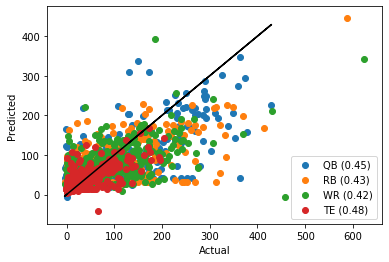

In [9]:
y_pred = {}
for pos in positions:
    m = linear_model.ElasticNetCV(l1_ratio=[x/10 for x in range (1,11)], max_iter=5000)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    coefs = pd.DataFrame([X_train[pos].columns,m.coef_]).transpose()
    display(coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose())
    
printStats(y_dev, y_pred)